In [25]:
import sys
sys.path.append('/home/centos/leon/machine_learning_jupyter')
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.externals import joblib 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from utils.sklearn_util import plot_learning_curve
%matplotlib inline

#### 加载样本

In [2]:
df_sample = pd.read_excel('/home/centos/leon/machine_learning_jupyter/dataset/collection_speech_sample.xlsx')
print('样本总数：{}, 正样本数：{}，负样本数：{}'.format(df_sample.shape[0], df_sample[df_sample['y'] == 1].shape[0], df_sample[df_sample['y'] == 0].shape[0]))
df_sample.head()

样本总数：1082, 正样本数：542，负样本数：540


,optimistic_0,optimistic_1,optimistic_2,optimistic_3,optimistic_4,optimistic_5,optimistic_6,optimistic_7,optimistic_8,optimistic_9,...,pessimistic_2,pessimistic_3,pessimistic_4,pessimistic_5,pessimistic_6,pessimistic_7,pessimistic_8,pessimistic_9,pessimistic_10,y
0,14,0,0,0,0,0,0,0,0,0,...,2,0,2,0,0,0,0,0,0,1
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
4,4,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


#### 使用 SVM 高斯模型训练

In [9]:
X = df_sample.iloc[:, :33].values
y = df_sample['y'].values.reshape([-1, ])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [12]:
# 设置参数矩阵
param_grid = {'C': np.linspace(0.1, 10, 50), 'gamma': np.linspace(0.1, 1, 10)}
clf = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=5)
clf.fit(X_train, y_train)
print 'best param: {}; best score: {}'.format(clf.best_params_, clf.best_score_)
best_param_C = clf.best_params_['C']
best_param_gamma = clf.best_params_['gamma']

best param: {'C': 1.5142857142857145, 'gamma': 0.10000000000000001}; best score: 0.938728323699


In [18]:
# 使用最优的高斯核函数拟合
model = svm.SVC(C=best_param_C, kernel='rbf', gamma=best_param_gamma, probability=True)

model.fit(X_train, y_train)
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
print 'train socre: {}, test score: {}'.format(train_score, test_score)

train socre: 0.976878612717, test score: 0.953917050691


#### 学习曲线

elaspe: 0.300000


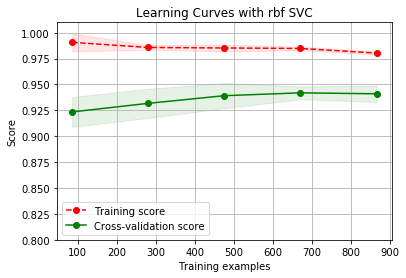

In [19]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
title = 'Learning Curves with rbf SVC'

start = time.clock()
plot_learning_curve(plt,
                    svm.SVC(C=best_param_C, kernel='rbf', gamma=best_param_gamma),
                    title, X, y, ylim=(0.8, 1.01), cv=cv, n_jobs=4)
print 'elaspe: {0:.6f}'.format(time.clock() - start)
plt.show()

#### ROC KS PR 曲线

AUC:  0.984451996602
最优概率划分： 0.453970685828
KS 值： 0.908071367884


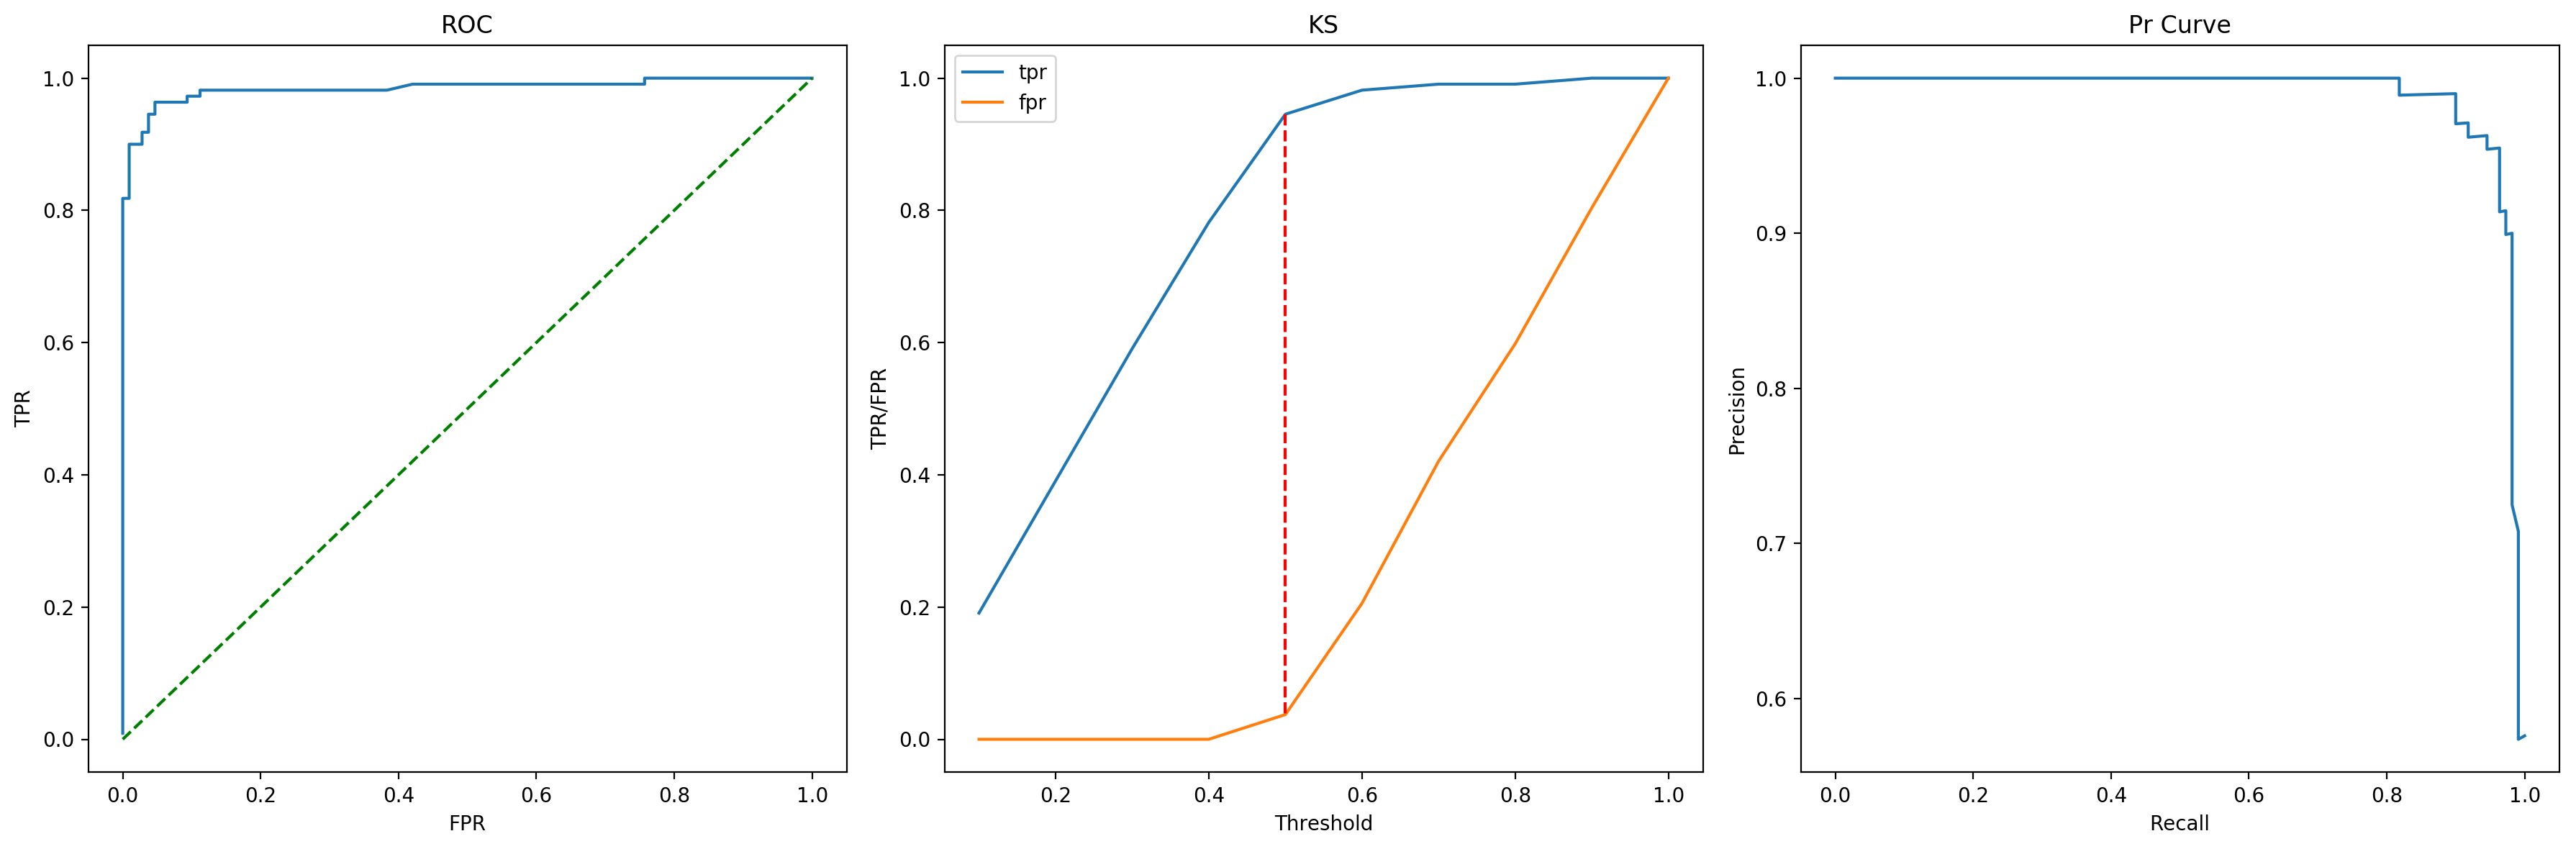

In [21]:
plt.figure(figsize=(18, 6), dpi=200)  

# 画 ROC 并计算 AUC，记录最佳划分概率
y_test_proba = model.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_proba[:, 1], pos_label=1)  # pos_label 指定积极的标签，可选参数
auc = metrics.auc(fpr, tpr)
print 'AUC: ', metrics.auc(fpr, tpr)
optimal_threshold = 0
optimal_split_proba = None
for i in range(len(thresholds)):
    if tpr[i] - fpr[i] > optimal_threshold:
        optimal_threshold = tpr[i] - fpr[i]
        optimal_split_proba = thresholds[i]
print '最优概率划分：', optimal_split_proba

plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, label='tp/fp')
plt.plot([0, 1], [0, 1], 'g--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')

plt.tight_layout()

# 计算 KS 曲线参数，并求解 KS 值
def gen_ks_params(df_predict, pos_label, add_up_thresholds):
    """
    计算 KS 曲线相关参数 和 KS 值
    :param df_predict: DataFrame, 预测结果，第0列（predict）为预测标签，第1列（predict_proba）为预测概率
    :param pos_label: int, 正样本的标签
    :param add_up_thresholds: list[float], 等份
    :return fpr, tpr, thresholds, ks, ks_xy: fpr 集合、tpr 集合、等份概率、ks 值、ks 值处的 xy 坐标
    """
    y_test_proba = df_predict.iloc[:, 1]
    y_test_apply_proba_sort = np.sort(y_test_proba)[::-1]
    count = len(y_test_apply_proba_sort)
    # 计算分为 10 等份时的概率阀值
    thresholds = []
    for add_up_threshold in add_up_thresholds:
        y_test_apply_proba_add_up = y_test_apply_proba_sort[:int(count * add_up_threshold)]
        add_up_count = len(y_test_apply_proba_add_up)
        threshold = y_test_apply_proba_add_up[add_up_count - 1]
        thresholds.append(threshold)
    
    tprs = []
    fprs = []
    ks = 0
    ks_xy = None
    i = 0
    for threshold in thresholds:
        tp = df_predict[(df_predict['predict'] == pos_label) & (df_predict['predict_proba'] >= threshold)].shape[0]
        fp = df_predict[(df_predict['predict'] != pos_label) & (df_predict['predict_proba'] >= threshold)].shape[0]
        fn = df_predict[(df_predict['predict'] == pos_label) & (df_predict['predict_proba'] < threshold)].shape[0]
        tn = df_predict[(df_predict['predict'] != pos_label) & (df_predict['predict_proba'] < threshold)].shape[0]

        tpr = 1.0 * tp / (tp + fn)
        fpr = 1.0 * fp / (fp + tn)
        if (tpr - fpr) > ks:
            ks = tpr - fpr
            ks_xy = [tpr, fpr, add_up_thresholds[i]]
        tprs.append(tpr)
        fprs.append(fpr)
        i += 1
    return fprs, tprs, thresholds, ks, ks_xy


df_predict = pd.DataFrame({'predict': y_test.tolist(), 'predict_proba': y_test_proba[:, 1].tolist()})
add_up_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
fprs, tprs, thresholds, ks, ks_xy = gen_ks_params(df_predict=df_predict, pos_label=1, add_up_thresholds=add_up_thresholds)
print 'KS 值：', ks

plt.subplot(1, 3, 2)
plt.plot(add_up_thresholds, tprs, label='tpr')
plt.plot(add_up_thresholds, fprs, label='fpr')
plt.plot([ks_xy[2], ks_xy[2]], [ks_xy[0], ks_xy[1]], 'r--')
plt.xlabel('Threshold')
plt.ylabel('TPR/FPR')
plt.title('KS')
plt.legend()
plt.tight_layout()

# 画出 PR 曲线
precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba[:, 1], pos_label=1)

plt.subplot(1, 3, 3)
plt.plot(recall, precision, label='pr')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Pr Curve')
plt.tight_layout()

plt.show()


#### 混淆矩阵

In [23]:
threshold = optimal_split_proba
y_true = []
y_pred = []

y_test_proba = model.predict_proba(X_test)
for i in range(len(y_test)):
    predict = y_test[i]
    predict_proba = y_test_proba[i][1]
    y_true.append('正类' if predict == 1 else '负类')
    y_pred.append('正类' if predict_proba >= threshold else '负类')
    pass
result = confusion_matrix(y_true, y_pred, labels=["正类", "负类"])
df = pd.DataFrame(data=result, columns=["预测正类", "预测负类"], index=["实际正类", "实际负类"])
df

,预测正类,预测负类
实际正类,106,4
实际负类,5,102


#### 保存模型

In [26]:
file_path = '/home/centos/leon/machine_learning_jupyter/module/collection_speech/collection_speech_clf.pkl'
joblib.dump(model, file_path)
print('模型已导出到：', file_path)

('\xe6\xa8\xa1\xe5\x9e\x8b\xe5\xb7\xb2\xe5\xaf\xbc\xe5\x87\xba\xe5\x88\xb0\xef\xbc\x9a', '/home/centos/leon/machine_learning_jupyter/module/collection_speech/collection_speech_clf.pkl')
